In [1]:
import os
from collections import OrderedDict
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import json
import reprlib
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data_anal = pd.read_csv("data_preproses clean.csv")

### Pelabelan dataset dengan InSet dan Sentistrength

In [3]:
# Memanfaatkan nltk VADER untuk menggunakan leksikon kustom
sia1A, sia1B, sia2 = SentimentIntensityAnalyzer(), SentimentIntensityAnalyzer(), SentimentIntensityAnalyzer()
# membersihkan leksikon VADER default
sia1A.lexicon.clear()
sia1B.lexicon.clear()
sia2.lexicon.clear()

# Membaca leksikon InSet
# Leksikon InSet lexicon dibagi menjadi dua, yakni polaritas negatif dan polaritas positif;
# kita akan menggunakan nilai compound saja untuk memberi label pada suatu kalimat
with open('_json_inset-neg.txt') as f:
    data1A = f.read()
with open('_json_inset-pos.txt') as f:
    data1B = f.read()
       
# Membaca leksikon sentiwords_id
with open('_json_sentiwords_id.txt') as f:
    data2 = f.read()


# Mengubah leksikon sebagai dictionary
insetNeg = json.loads(data1A)
insetPos = json.loads(data1B)
senti = json.loads(data2)

# Update leksikon VADER yang sudah 'dimodifikasi'
sia1A.lexicon.update(insetNeg)
sia1B.lexicon.update(insetPos)
sia2.lexicon.update(senti)

print(reprlib.repr(sia1A.lexicon))
print(reprlib.repr(sia1B.lexicon))
print(reprlib.repr(sia2.lexicon))

{'(barang) bekas': -4, '(olahraga) bokser': -5, '(tua) uzur': -3, 'Anda': -4, ...}
{'(hujan) gerimis': 1, '(warna) dadu': 3, 'Ahad': 3, 'Sri paduka': 4, ...}
{'abadi': 5, 'absen': -3, 'abu-abu': -1, 'acuh': 4, ...}


#### Contoh menggunakan kalimat untuk mencari polarity

In [4]:
sample = "lha siapa tahu kalau jadi kipi kalau tahu sakit pastinya gak vaksin"
print("insetNeg: ", sia1A.polarity_scores(sample))
print("insetPos: ", sia1B.polarity_scores(sample))
print("insetCpdSum: 'compound':", sia1A.polarity_scores(sample)["compound"] + sia1B.polarity_scores(sample)["compound"])

print("senti\t: ", sia2.polarity_scores(sample))

insetNeg:  {'neg': 0.839, 'neu': 0.161, 'pos': 0.0, 'compound': -0.9799}
insetPos:  {'neg': 0.0, 'neu': 0.364, 'pos': 0.636, 'compound': 0.9325}
insetCpdSum: 'compound': -0.0474
senti	:  {'neg': 0.312, 'neu': 0.688, 'pos': 0.0, 'compound': -0.7184}


## Fungsi untuk mengklasifikasikan kalimat sebagai negatif/positif berdasarkan nilai compound

In [5]:
def is_positive_inset(tweet: str) -> bool:
    """True if tweet has positive compound sentiment, False otherwise."""
    return sia1A.polarity_scores(tweet)["compound"] + sia1B.polarity_scores(tweet)["compound"] > 0

def is_positive_senti(tweet: str) -> bool:
    """True if tweet has positive compound sentiment, False otherwise."""
    return sia2.polarity_scores(tweet)["compound"] > 0

In [7]:
# Membaca data yang sudah dibersihkan dari karakter yang tidak diperlukan serta dari daftar kata tak baku dan stop words
os.chdir("Output1")
base = "data_preproses clean.csv"

In [12]:
tweets = data_anal["tweet"].astype(str)

# Menulis hasil klasifikasi label untuk setiap kalimat berdasarkan nilai compound dari insetNeg dan insetPos
output = os.path.splitext(base)[0]+'-lb-inset.txt'
with open(output, 'w') as f:
    for tweet in tweets:
        if is_positive_inset(tweet) == True:
            label = "pos"
        else:
            label = "neg"
        f.write(str(label+'\n'))

# Menulis hasil klasifikasi label untuk setiap kalimat berdasarkan nilai compound dari SentiStrength
output = os.path.splitext(base)[0]+'-lb-senti.txt'
with open(output, 'w') as f:
    for tweet in tweets:
        if is_positive_senti(tweet) == True:
            label = "pos"
        else:
            label = "neg"
        f.write(str(label+'\n'))

### Distribusi kelas positif & negatif

In [13]:
lb_inset = 'data_preproses clean-lb-inset.txt'
lb_senti = 'data_preproses clean-lb-senti.txt'
#x0 = pd.read_csv(lb_actual, header=None,names=['text'], usecols=['label'])
x1 = pd.read_csv(lb_inset, header=None, names=['label'])
x2 = pd.read_csv(lb_senti, header=None, names=['label'])


df = pd.DataFrame()
df.insert(0, 'InSet', x1['label'])
df.insert(1, 'sentistrength_id', x2['label'])
#
print(df)

    InSet sentistrength_id
0     neg              neg
1     neg              neg
2     neg              pos
3     neg              neg
4     neg              neg
..    ...              ...
991   pos              neg
992   neg              neg
993   pos              neg
994   neg              neg
995   neg              neg

[996 rows x 2 columns]


In [14]:
neg1 = df['InSet'].str.count('neg').sum()
pos1 = df['InSet'].str.count('pos').sum()
sum1 = neg1+pos1

neg2 = df['sentistrength_id'].str.count('neg').sum()
pos2 = df['sentistrength_id'].str.count('pos').sum()
sum2 = neg2+pos2

print('negatives:',neg1,', positives:',pos1,', total:',sum1, '\t| inSet')
print('negatives:',neg2,', positives:',pos2,', total:',sum2, '\t| senti')

print('{:.2f}'.format(neg1/sum1*100),':', '{:.2f}'.format(pos1/sum1*100), '\t| inSet')
print('{:.2f}'.format(neg2/sum2*100),':', '{:.2f}'.format(pos2/sum2*100), '\t| senti')

negatives: 635 , positives: 361 , total: 996 	| inSet
negatives: 741 , positives: 255 , total: 996 	| senti
63.76 : 36.24 	| inSet
74.40 : 25.60 	| senti


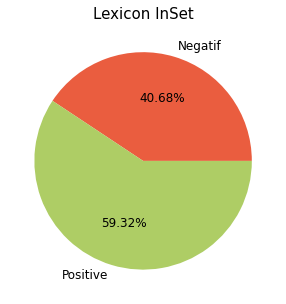

In [15]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Negatif', 'Positive'
sizes = [40.68, 59.32]
colors = ('#EA5D3F', '#AECD65')

fig = plt.figure(figsize=(5,5))
ax = plt.axes()
ax.pie(sizes, labels = labels, autopct='%.2f%%', colors=colors, textprops={'fontsize': 12})
ax.set_title('Lexicon InSet', fontsize=15)
plt.show()

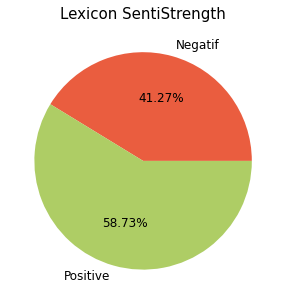

In [16]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Negatif', 'Positive'
sizes = [41.27, 58.73]
colors = ('#EA5D3F', '#AECD65')

fig = plt.figure(figsize=(5,5))
ax = plt.axes()
ax.pie(sizes, labels = labels, autopct='%.2f%%', colors=colors,  textprops={'fontsize': 12})
ax.set_title('Lexicon SentiStrength', fontsize=15)
plt.show()